# Import, lettura dei file e prime trasformazioni

Importo le librerie necessarie e leggo i file

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup


link = 'https://docs.google.com/spreadsheets/d/1lqaobayFAdTrGP4l8uFyK8YYm7ixO4IHO--nRjk23zY'
sheet_name = 'Foglio1'
url = link + '/gviz/tq?tqx=out:csv&sheet='+sheet_name
path = './data/bilancio_test.xml' #specificare il path

Lettura del file XML del bilancio e salvataggio di un dizionario con i dati utili

In [2]:
#lettura del file di bilancio

#next step rendere più automatico questa estrazione testuale
data_to_extract = ['patrimonionettoutileperditaesercizio', 'utileperditaesercizio', 'differenzavalorecostiproduzione',
                  'risultatoprimaimposte', 'totalecreditiversosociversamentiancoradovuti',
                  'patrimonionettocapitale', 'costiproduzioneoneridiversigestione', 'attivorateirisconti',
                  'totalerimanenze', 'valoreproduzionevariazionirimanenzeprodotticorsolavorazionesemilavoratifiniti',
                  'valoreproduzionealtriricaviproventicontributicontoesercizio', 'valoreproduzionealtriricaviproventitotalealtriricaviproventi',
                  'patrimonionettoaltreriservedistintamenteindicatetotalealtreriserve','totaledisponibilitaliquide',
                  'totaleimmobilizzazioniimmateriali', 'costiproduzionematerieprimesussidiarieconsumomerci',
                  'totaleimmobilizzazioni', 'totalepatrimonionetto', 'totalecrediti', 'creditiesigibilientroeserciziosuccessivo',
                  'valoreproduzionericavivenditeprestazioni','totalevaloreproduzione','patrimonionettoriservasoprapprezzoazioni',
                  'costiproduzioneservizi','totaledebiti', 'debitiesigibilientroeserciziosuccessivo',
                  'totaleattivocircolante', 'totalecostiproduzione', 'totaleattivo', 'totalepassivo']



#creazione di un dizionario avente come chiavi le diciture del bilancio e come valori il valore
with open(path, 'r') as f:
    data = f.read()

dict_bilancio = {}
    
bs_data = BeautifulSoup(data, "xml")

dict_bilancio = {}

b_val = bs_data.find_all('totaleattivocircolante')
for el in data_to_extract:
    b_val = bs_data.find_all(el)
    dict_bilancio[el] = float(b_val[0].get_text().replace('\n','').replace(' ',''))


Lettura del file delle transazioni

In [3]:
#lettura delle transazioni e prime trasformazioni 
df_transaction = pd.read_csv(url)
df_transaction['data '] = pd.to_datetime(df_transaction['data '])
df_transaction['amount'] = df_transaction['amount'].apply(lambda x: float(x.replace('€ ', '').replace('.','').replace(',',''))/100)
df_transaction.rename(columns = {'data ': 'date', 'categoria':'category'}, inplace = True)
df_transaction['month'] = df_transaction['date'].dt.month

In [4]:
# raggruppamento delle transazioni per mese e per categoria
df_transaction_month = df_transaction.groupby(['month', 'category']).agg({'amount':['sum', 'count', 'mean']}).reset_index()
df_transaction_month.columns = ['month', 'category', 'sum_amount', 'count_amount', 'mean_amount']

# Analisi Transazioni 2022

## Analisi Transazioni Negative

Analizziamo le transazioni negative mensili partendo da un semplice trend per ogni categoria di costo.

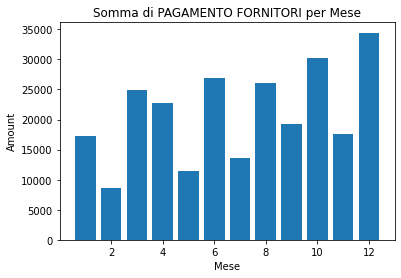

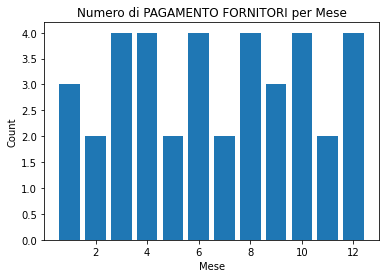

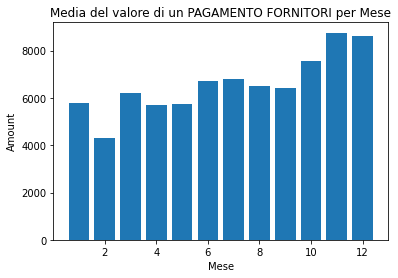

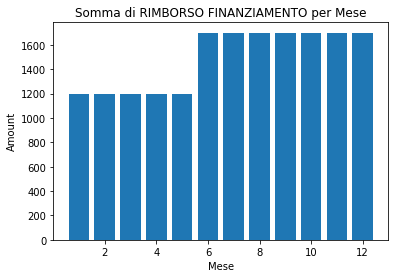

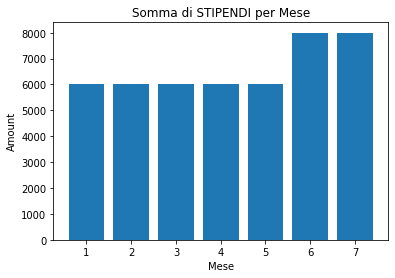

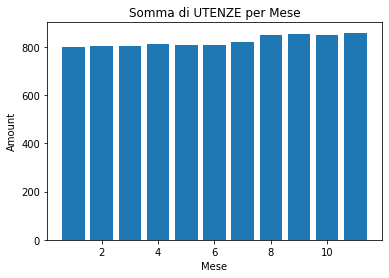

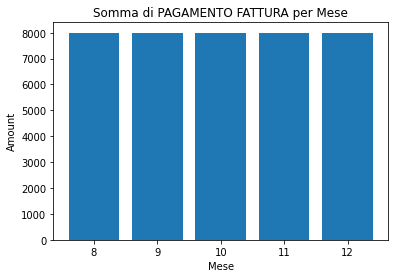

In [5]:
cat_neg = ['PAGAMENTO FORNITORI', 'RIMBORSO FINANZIAMENTO','STIPENDI', 'UTENZE','PAGAMENTO FATTURA']

for cat in cat_neg:
    
    df_cat_mesile = df_transaction_month[df_transaction_month.category==cat].copy()
    df_cat_mesile['sum_amount'] = (-1) * df_cat_mesile['sum_amount']

    #sum
    fig, ax = plt.subplots()

    ax.bar(df_cat_mesile['month'], df_cat_mesile['sum_amount'])
    ax.set_ylabel('Amount')
    ax.set_xlabel('Mese')
    ax.set_title(f'Somma di {cat} per Mese')
    
    if cat =='PAGAMENTO FORNITORI':
        #count
        fig, ax = plt.subplots()

        ax.bar(df_cat_mesile['month'], df_cat_mesile['count_amount'])
        ax.set_ylabel('Count')
        ax.set_xlabel('Mese')
        ax.set_title(f'Numero di {cat} per Mese')

        #mean
        df_cat_mesile['mean_amount'] = (-1) * df_cat_mesile['mean_amount']
        
        fig, ax = plt.subplots()
        ax.bar(df_cat_mesile['month'], df_cat_mesile['mean_amount'])
        ax.set_ylabel('Amount')
        ax.set_xlabel('Mese')
        ax.set_title(f'Media del valore di un {cat} per Mese')
        
plt.show()

Il trend del pagamento dei fornitori è crescente nel corso dei mesi e si può notare anche dal prezzo del pagamento medio per ogni mese.

Si nota inoltre che a Maggio c'è stato un incasso di un finanziamento e da Giugno in poi viene pagato una nuova rata di 500 euro che si va a sommare alle precedenti che erano di 1200 mensili.

L'erogazione del finanziamento è di 10000 euro la rata del rimborso è di 500, quindi (supponendo rimanga costante) si può constatare che continuerà ad essere presente anche per tutto il 2023.

Le utenze hanno un leggero trend crescente che però può essere considerato quasi trascurabile: un aumento di circa 50 euro tra le spese di inizio 2022 e la fine del 2022.

Notando che da Agosto in poi non esistono più gli stipendi nelle transazioni e che fino ad Agosto non esisteva aìla categoria PAGAMENTO FATTURA, si può supporre che queste categorie possano essere riunite in una unica nella nostra analisi.
Inoltre si può notare come gli stipendi siano sempre 6000 fino a Maggio e da Giugno in poi siano 8000 come il valore mensile di Pagamento Fattura.


## Analisi Incassi

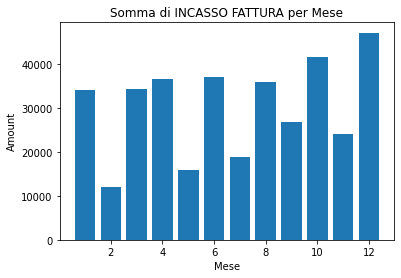

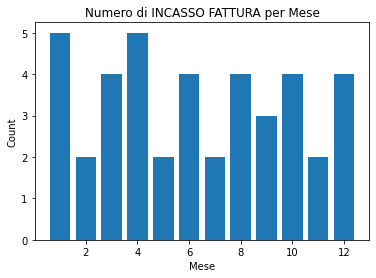

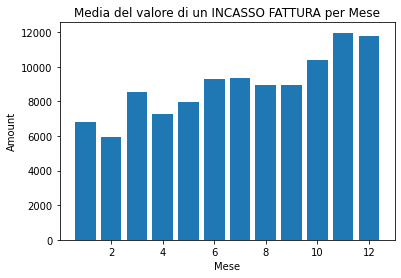

In [6]:
cat = 'INCASSO FATTURA'
    
df_cat_mesile = df_transaction_month[df_transaction_month.category==cat].copy()
df_cat_mesile['sum_amount'] = df_cat_mesile['sum_amount']

#Plot della somma delle fatture per mese
fig, ax = plt.subplots()

ax.bar(df_cat_mesile['month'], df_cat_mesile['sum_amount'])
ax.set_ylabel('Amount')
ax.set_xlabel('Mese')
ax.set_title(f'Somma di {cat} per Mese')

#Plot del count delle fatture per mese
fig, ax = plt.subplots()

ax.bar(df_cat_mesile['month'], df_cat_mesile['count_amount'])
ax.set_ylabel('Count')
ax.set_xlabel('Mese')
ax.set_title(f'Numero di {cat} per Mese')

#Plot dell'importo medio delle fatture per mese
fig, ax = plt.subplots()

ax.bar(df_cat_mesile['month'], df_cat_mesile['mean_amount'])
ax.set_ylabel('Amount')
ax.set_xlabel('Mese')
ax.set_title(f'Media del valore di un {cat} per Mese')

plt.show()

Il trend dell'INCASSO FATTURA è crescente nel corso dei mesi e si può notare anche dal prezzo del pagamento medio per ogni mese, lo stesso comportamento si è riscontrato nel PAGAMENTO FORNITORI.

## Studio del Margine Mensile

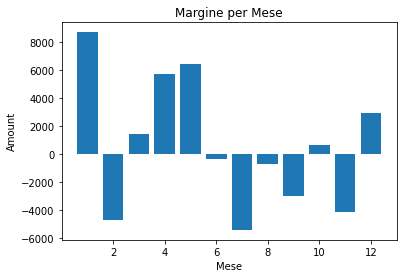

La somma totale, considerando l'erogazione di finanziamento di 10000 euro, tra incassi e spese è: 7525 euro
La somma totale, considerando l'erogazione di una stima (35%) della parte di finanziamento ripagata, tra incassi e spese è: 1025 euro
La somma totale, considerando i mesi successivi al finanziamento e considerando le rate dovute al rimborso del finanziamento, tra incassi e spese è: -20006 euro


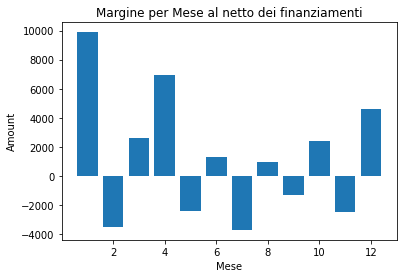

La somma totale, al netto dei finanziamenti, tra incassi e spese è: 15425 euro
La media per mese, al netto dei finanziamenti, tra incassi e spese è: 1285 euro
La media per mese da Giugno in poi, al netto dei finanziamenti, tra incassi e spese è: 270 euro


In [7]:
df_filtered = df_transaction_month.copy()
df_filtered = df_filtered.groupby('month').agg({'sum_amount':'sum'}).reset_index()

fig, ax = plt.subplots()

ax.bar(df_filtered['month'], df_filtered['sum_amount'])
ax.set_ylabel('Amount')
ax.set_xlabel('Mese')
ax.set_title(f'Margine per Mese')

plt.show()

print(f"La somma totale, considerando l'erogazione di finanziamento di 10000 euro, tra incassi e spese è: \
{int(df_transaction_month.sum_amount.sum())} euro")
print(f"La somma totale, considerando l'erogazione di una stima (35%) della parte di finanziamento ripagata, tra incassi e spese è: \
{int(df_transaction_month.sum_amount.sum() - 6500)} euro")
print(f"La somma totale, considerando i mesi successivi al finanziamento e considerando le rate dovute al rimborso del finanziamento, \
tra incassi e spese è: \
{int(df_transaction_month[df_transaction_month.month>=6].sum_amount.sum() - 10000)} euro")


df_filtered = df_transaction_month[~(df_transaction_month.category.isin(['EROGAZIONE FINANZIAMENTO', 'RIMBORSO FINANZIAMENTO']))].copy()
df_filtered = df_filtered.groupby('month').agg({'sum_amount':'sum'}).reset_index()
fig, ax = plt.subplots()

ax.bar(df_filtered['month'], df_filtered['sum_amount'])
ax.set_ylabel('Amount')
ax.set_xlabel('Mese')
ax.set_title(f'Margine per Mese al netto dei finanziamenti')

plt.show()
                                                                      

print(f"La somma totale, al netto dei finanziamenti, tra incassi e spese è: {int(df_filtered.sum_amount.sum())} euro")
print(f"La media per mese, al netto dei finanziamenti, tra incassi e spese è: {int(df_filtered.sum_amount.mean())} euro")
print(f"La media per mese da Giugno in poi, al netto dei finanziamenti, tra incassi e spese è: \
{int(df_filtered[df_filtered.month>=6].sum_amount.mean())} euro")


Da quando è stato erogato il finanziamento (a Maggio) e da quando sono state aumentate le spese mensili degli stipendi, le spese mensili superano sempre gli incassi, tranne nel mese di Dicembre. In generale non sembra che la situazione dell'azienda ABC possa permetere un ulteriore finanziamento essendo sempre in difficoltà ad affrontare le proprie spese mensili.

Facendo una stima ipotetica in cui il tasso di interesse del finanziamento sia nullo si può ipotizzare che con una rata mensile di 500, si siano ripagati circa il 35% di finanziamento (stimando un costo del finanziamento pari a 0).

Guardando solo il rapporto tra incassi e costi fissi non dovuti a finanziamenti si può vedere come la maggior parte degli utili sia nei primi 5 mesi (periodo precedente al finanziamento e all'aumento del costo degli stipendi) mentre nei mesi successivi si rimane molto vicini al pareggio (+270 euro al mese).



# Analisi Bilancio

In [8]:
dict_bilancio

{'patrimonionettoutileperditaesercizio': -94264.0,
 'utileperditaesercizio': -94264.0,
 'differenzavalorecostiproduzione': -94264.0,
 'risultatoprimaimposte': -94264.0,
 'totalecreditiversosociversamentiancoradovuti': 33.0,
 'patrimonionettocapitale': 209.0,
 'costiproduzioneoneridiversigestione': 939.0,
 'attivorateirisconti': 1765.0,
 'totalerimanenze': 3000.0,
 'valoreproduzionevariazionirimanenzeprodotticorsolavorazionesemilavoratifiniti': 3000.0,
 'valoreproduzionealtriricaviproventicontributicontoesercizio': 4000.0,
 'valoreproduzionealtriricaviproventitotalealtriricaviproventi': 4260.0,
 'patrimonionettoaltreriservedistintamenteindicatetotalealtreriserve': 50000.0,
 'totaledisponibilitaliquide': 54891.0,
 'totaleimmobilizzazioniimmateriali': 74819.0,
 'costiproduzionematerieprimesussidiarieconsumomerci': 75461.0,
 'totaleimmobilizzazioni': 77584.0,
 'totalepatrimonionetto': 85927.0,
 'totalecrediti': 87895.0,
 'creditiesigibilientroeserciziosuccessivo': 87895.0,
 'valoreproduzio

Mi sono aiutato riscrivendomi il bilancio sottoforma di commento 

In [9]:
#CONTO ECONOMICO
#dict_bilancio['totalevaloreproduzione'] - dict_bilancio['totalecostiproduzione'] = -94264.0

# dict_bilancio['totalevaloreproduzione'] = 118315.0
#     dict_bilancio['valoreproduzionericavivenditeprestazioni'] = 111055.0
#     dict_bilancio['valoreproduzionealtriricaviproventitotalealtriricaviproventi'] = 4260.0
#     dict_bilancio['valoreproduzionevariazionirimanenzeprodotticorsolavorazionesemilavoratifiniti'] = 3000.0

# dict_bilancio['totalecostiproduzione'] = 212579.0
#     dict_bilancio['costiproduzionematerieprimesussidiarieconsumomerci'] = 75461.0
#     dict_bilancio['costiproduzioneservizi'] = 136179.0
#     dict_bilancio['costiproduzioneoneridiversigestione'] = 939.0

In [10]:
#PASSIVO
# dict_bilancio['totalepatrimonionetto'] = 85927.0 
# dict_bilancio['totaledebiti'] = 139241.0
#     dict_bilancio['debitiesigibilientroeserciziosuccessivo'] = 139241.0

In [11]:
#ATTIVO
# dict_bilancio['totaleattivocircolante'] = 145786.0,
# dict_bilancio['totaleimmobilizzazioni'] = 77584.0,
# dict_bilancio['attivorateirisconti'] = 1765.0,
# dict_bilancio['totalecrediti'] =  87895.0,
    # dict_bilancio['creditiesigibilientroeserciziosuccessivo'] = 87895.0,

In [12]:
print(f"La differenza tra debiti e crediti è {dict_bilancio['debitiesigibilientroeserciziosuccessivo'] - dict_bilancio['creditiesigibilientroeserciziosuccessivo']} euro")
fin_2022 = df_transaction_month[df_transaction_month.category.isin(['EROGAZIONE FINANZIAMENTO'])].sum_amount.sum()
print(f"I finanziamenti erogati nel corso del 2022 sono {fin_2022} euro")
fin_rimb_2022 = (-1) * df_transaction_month[df_transaction_month.category.isin(['RIMBORSO FINANZIAMENTO'])].sum_amount.sum()
print(f"I finanziamenti rimborsati nel corso del 2022 sono {fin_rimb_2022} euro")



La differenza tra debiti e crediti è 51346.0 euro
I finanziamenti erogati nel corso del 2022 sono 10000.0 euro
I finanziamenti rimborsati nel corso del 2022 sono 17900.0 euro


Il risultato prima delle imposte è fortemente negativo -94264 euro. Questo significa che l'azienda non è in grado di autofinanziarsi e di generare ricchezza. In particolare si può vedere che le spese si compongano in maggior parte nei costi di produzione servizi (64%) e costi di materie prime (35%).

Tuttavia è interessante notare che nel 2022 questo dato sembra migliorato.

I debiti estinguibili durante l'esercizio successivo sono 51346 euro. I finanziamenti erogati nel corso del 2022 sono 10000 euro. I finanziamenti rimborsati nel corso del 2022 sono 17900 euro. Per cui rimane un forte indebitamento dell'azienda ABC

Crescita del rapporto ricavi costi 2022 vs 2021: 

In [13]:
ricavi_2022 = df_transaction_month[df_transaction_month.category.isin(['INCASSO FATTURA'])].sum_amount.sum()
#consideriamo valore produzione ricavivendite prestazioni e valore produzione altri ricavi proventi totale altri ricavi proventi
ricavi_2021 = dict_bilancio['valoreproduzionericavivenditeprestazioni'] \
    + dict_bilancio['valoreproduzionealtriricaviproventitotalealtriricaviproventi']
print(f"La crescita in valore assoluto dei ricavi dal 2021 al 2022 è del {int((ricavi_2022 - ricavi_2021))} euro")
print(f"La crescita percentuale dei ricavi dal 2021 al 2022 è del {int((ricavi_2022 - ricavi_2021)*100/ricavi_2021)}%")

# consideriamo solo 'PAGAMENTO FORNITORI','STIPENDI', 'UTENZE','PAGAMENTO FATTURA'
list_costi = ['PAGAMENTO FORNITORI','STIPENDI', 'UTENZE','PAGAMENTO FATTURA']
costi_2022 = (-1) * df_transaction_month[df_transaction_month.category.isin(list_costi)].sum_amount.sum()
costi_2021 = dict_bilancio['costiproduzionematerieprimesussidiarieconsumomerci'] + dict_bilancio['costiproduzioneservizi']
print(f"La crescita in valore assoluto dei costi legati alla produzione dal 2021 al 2022 è del {int((costi_2022 - costi_2021))} euro")
print(f"La crescita percentuale dei costi legati alla produzione dal 2021 al 2022 è del {int((costi_2022 - costi_2021)*100/ricavi_2021)}%")

La crescita in valore assoluto dei ricavi dal 2021 al 2022 è del 248218 euro
La crescita percentuale dei ricavi dal 2021 al 2022 è del 215%
La crescita in valore assoluto dei costi legati alla produzione dal 2021 al 2022 è del 136468 euro
La crescita percentuale dei costi legati alla produzione dal 2021 al 2022 è del 118%


# Conclusione

Non erogherei nessun prestito all'azienda in quanto non sembra un'attività che in grado di sostenere un ulteriore finaziamento.

Motivazione:
- (INDEBITAMENTO) : la differenza tra i debiti estinguibili durante l'esercizio successivo e i crediti estinguibili durante l'esercizio successivo a bilancio 2021 è 51346 euro. I finanziamenti erogati nel corso del 2022 sono 10000 euro. I finanziamenti rimborsati nel corso del 2022 sono 17900 euro. Per cui rimane un forte indebitamento dell'azienda ABC.


- (MARGINE VALORE DELLA PRODUZIONE - COSTI DELLA PRODUZIONE) : limitandosi ad analizzare gli ultimi 7 mesi del 2023, quando il costo del personale è aumentato di 2000 euro, il margine tra incassi e costi della produzione (al netto dei RIMBORSI FINANZIAMENTO) medio mensile è di solo 270 euro. Se consideriamo tutto l'anno 2022 la media mensile è di 1285 euro.
Tuttavia se analizziamo anche le rate di rimborso finanziamento (1200 euro nei primi 5 mesi, 1700 euro da Giugno in poi, dovuto a un finanziamento di 10000 euro ottenuto a fine Maggio), si può dedurre come il margine nei prossimi mesi probabilmente non consentirà all’azienda ABC di ripagare un ulteriore finanziamento in breve termine.


L'unico aspetto positivo riscontrato nell'analisi è il trend positivo tra l'andamento del 2021 e l'andamento del 2022. Nel 2021 era un'azienda in una situazione molto negativa con costi molto maggiori degli incassi, mentre nel 2023 la situazione è cambiata e l'azienda sembra iniziare a produrre valore. Questo è confermato dalla crescita maggiore sia in termini percentuali che assoluti del valore della produzione rispetto ai costi della produzione. Quindi  potrebbe essere un'azienda candidabile nei prossimi anni ad un finanziamento.